In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Problem Statement

## Background

The novel coronavirus COVID-19 is a new strain of virus that belongs to the acute respiratory syndromes. The outbreak was first identified in China around November 2019 and have since evolved to a worldwide pandemic.  

Amongst medical supplies, many countries facing the brunt of the pandemic are also facing [shortages of healthcare workers]( https://www.abc.net.au/news/2021-07-14/trainee-doctors-on-the-front-line-of-indonesia-covid-disaster/100285804), namely developed countries like Indonesia, India, and Philippines.  
 
The exponential spread of COVID-19, and the increasing number of healthcare workers that has fallen victim to the virus,  has led to a demand in technology that can help alleviate the  stress this virus has created in the healthcare industry. 


## The role of Chest Radiographs (CXR) in treating COVID-19
Chest radiographs (CXR) are widely used for the screening and management of COVID-19.  

As hospitals has reached maximum capacity, a positive reverse transcription polymerase chain reaction (RT-PCR) test is no longer the deciding factor for doctors to admit patients. Instead, CXR results have now become an essential tool to determine which patients should be prioritised for hospital treatment.  

Aside from that, patients who have recovered from COVID-19 may still suffer from chronic lung abnormalities that would be fatal if early prevention is not performed.


## Challenges of Diagnosing COVID-19 Pneumonia in CXR

Findings of COVID-19 in CXR can be very subtle, in one [study](https://pubs.rsna.org/doi/full/10.1148/radiol.2020200823) that measures the sensitivity of COVID-19 amongst China and US radiologists, it was shown that the average sentivities of radiologists in identifying COVID-19 pneumonia is 80.4%.

We will use this as an industry benchmark when evaluating the model.



## Using AI to help diagnose the presence of COVID-19 Pneumonia
In this project, our aim is to help create an early warning tool for the detection of COVID-19 pneumonia to alleviate some of the load on radiologists. Since we are predicting a fatal and highly contagious virus, we will focus on minimizing false negatives, prioritizing sensitivity as a score.  


#Importing Libraries

In [21]:
%matplotlib inline

import os
import shutil
import random
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import argparse
import time


from PIL import Image
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from torch.optim.lr_scheduler import ReduceLROnPlateau

torch.manual_seed(0)

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.9.0+cu102


# Preparing Training and Test Sets

## Separate Train and Test Dataset 

In [22]:

class_names = {'normal','thoraxdisease', 'covid'}
root_dir = '/content/drive/MyDrive/Capstone/Dataset/'
source_dirs = {'normal','thoraxdisease', 'covid'}

if os.path.isdir(os.path.join(root_dir, 'test'))==False:
    #create a new folder for test images
    os.mkdir(os.path.join(root_dir, 'test'))

    # rename source names with class names 
    for i, d in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))

    #create a new folder for each class
    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'test', c))

    # for each class split 15% of images from original folder to test folder
    for c in class_names:
        # create a list of all images in original class folder
        images = [x for x in os.listdir(os.path.join(root_dir, c)) if any(x.lower().endswith(s) for s in ['.png', '.jpeg','.jpg'])]
        # create a list of random images from each original class folder
        selected_images = random.sample(images, round(len(images)*0.15))
        # move selected random images from original folder to new folder
        for image in selected_images:
            source_path = os.path.join(root_dir, c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)
    

## Create a Dataset Class

In [23]:
# creating a custom dataset in pytorch
class ChestXRayDataset(torch.utils.data.Dataset):
     # instantiating a dataset object
    def __init__(self, image_dirs, transform):
      def get_images(class_name):
        # list of images from chosen folder
        images = os.listdir(image_dirs[class_name]) 
        # print out no. of images found for respective class
        print(f'Found {len(images)} {class_name} examples')
        # get list of images for the said class
        return images
    
      self.images = []
      self.labels = []
      #instantiate a list of classes
      self.class_names = ['normal','thoraxdisease', 'covid']

      for class_name in self.class_names:
        images = get_images(class_name)
        # list containing all the images
        self.images.extend(images)
        # list containing all the corresponding image labels
        self.labels.extend([class_name]*len(images))

      # initialize directory containing images    
      self.image_dirs = image_dirs
      # set transformers for images
      self.transform = transform
         
    # function that returns no. of samples in dataset
    def __len__(self):
        # count total image
        return len(self.images)
    
    # function loads and returns a sample from the dataset at the given index 
    def __getitem__(self, index):
        # image at index position of all the images
        image_name = self.images[index]
        # Its label 
        class_name = self.labels[index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        #convert to RGB as model input needs to be RGB
        image = Image.open(image_path).convert('RGB')
        return image_name,self.transform(image), self.class_names.index(class_name)

## Set Image Transformers

#### Random Horizontal Flip
X-ray images can either be projected as Posterior Anterior (PA) or Anterior Posterior (AP). Erect PA projections are considered the ‘gold standard’ for chest projection imaging (CXR). However, such projections may not be possible depending on the state of the patient, as such we will create variability in the dataset using random horizontal flip to simulate such occurences.

#### Image Normalization
Used to increase contrast aiding in improved feature extraction or image segmentation. We will use the original normalization used by the pretrained Resnet18 models to remove noise from pictures in the ImageNet dataset.

In [24]:
#transforms and augments images for train dataset
train_transform = torchvision.transforms.Compose([
    # standardize size of images to expected input by Resnet18                                             
    torchvision.transforms.Resize(size=(224, 224)),
    # each epoch will have probability original/horizontally flipped of 0.5 (increase variation)
    torchvision.transforms.RandomHorizontalFlip(),
    # change numpy array to tensor because pytorch uses tensor as input
    torchvision.transforms.ToTensor(),
    # normalize transformation to match Imagenet normalization for Resnet18 
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#transforms and augments images for train dataset

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

## Load Images into Dataset Class

In [25]:
#create a custom dataset for training images
train_dirs = {
    'normal': '/content/drive/MyDrive/Capstone/Dataset/train/normal',
    'thoraxdisease': '/content/drive/MyDrive/Capstone/Dataset/train/thoraxdisease',
    'covid': '/content/drive/MyDrive/Capstone/Dataset/train/covid',
}

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1197 normal examples
Found 3176 thoraxdisease examples
Found 309 covid examples


In [26]:
#create a custom dataset for test images
test_dirs = {
    'normal': '/content/drive/MyDrive/Capstone/Dataset/test/normal',
    'thoraxdisease': '/content/drive/MyDrive/Capstone/Dataset/test/thoraxdisease',
    'covid': '/content/drive/MyDrive/Capstone/Dataset/test/covid',
}

test_dataset = ChestXRayDataset( test_dirs, test_transform)

Found 211 normal examples
Found 560 thoraxdisease examples
Found 54 covid examples


## Making Dataset Iterable

The Dataset retrieves our dataset’s features and labels one sample at a time. While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.



In [27]:
batch_size = 6
# create an iterable dataset of batch size 6 
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# check number of batches is dataloader
print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 781
Number of test batches 138


In [28]:
train_name, train_features, train_labels = next(iter(dl_train))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")


Feature batch shape: torch.Size([6, 3, 224, 224])
Labels batch shape: torch.Size([6])


In [29]:
class_names = train_dataset.class_names

# create a function to display images from iterable dataset
def show_images(file_name, images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
        
    plt.tight_layout()
    plt.show()
    print(f'{file_name}')

# Exploratary Data Analysis


####  Features of Normal Lung X-Rays [source](https://discovery.ucl.ac.uk/id/eprint/10103410/3/Jones_submitted%20version.pdf)

*   Central medistinum and heart appear normal
*   Lungs predominantly contain air (predominantly black)
*   Lung markings are present, representing blood vessels extending from hilum to the lung periphery (these branch and decrease in calibre, such that few vessels are seen at the lung periphery)
*   The diaphragm is curbilinear in outline with sharp costophrenic magins

#### Features of COVID-19 Pneumonia Lung X-Rays [Source](https://discovery.ucl.ac.uk/id/eprint/10103410/3/Jones_submitted%20version.pdf)

Ground Glass Opacity
*   Loss of the normal black appearance in the lung. This is seen as increased whiteness, (because of increased density) but not enough to totally obscure lung markings; giving ground glass appearance. 
*   Horizontal linear opacities  may be seen with ground glass change
*   This is usually bilateral but can be unilateral. More often reported in a peripheral lung adjacent to the chest wall and disphragm and usually with a distribution in the mid and lower zones. Approximately 20% of patients with COVID-19  pneumonia develop ground glass opacities in the right upper zone of the lung.

Consolidation

*   Ground-glass opacities become denser (whiter) and progress to consolidation with compelte loss of lung markings The areas of consolidation are likely to progress from sites of ground glass opacities.



#### Features of Thorax Disease Lung X-Rays [Source](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf)


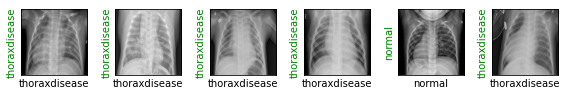

('person75_bacteria_369.jpeg', 'person106_virus_194.jpeg', 'person1358_bacteria_3463.jpeg', 'person1083_virus_1795.jpeg', 'IM-0201-0001.jpeg', 'person658_bacteria_2550.jpeg')


In [30]:
file_name, images, labels = next(iter(dl_train))
show_images(file_name, images, labels, labels)

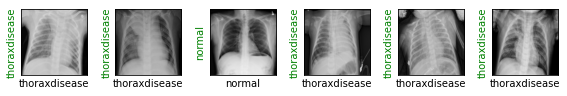

('person1496_bacteria_3909.jpeg', 'person1481_bacteria_3868.jpeg', '00000291_000.png', 'person23_bacteria_82.jpeg', 'person1328_virus_2294.jpeg', 'person1375_bacteria_3510.jpeg')


In [31]:
file_name, images, labels= next(iter(dl_test))
show_images(file_name, images, labels, labels)

# Building the Neural Network

### Loading Pretrained Resnet18 Model

In [32]:
#load resnet18 pretrained model 
resnet18 = torchvision.models.resnet18(pretrained=True)

#freeze weights in pretrained model (remove if we want to hypertune and update the weights)
# for param in resnet18.parameters():
#     param.requires_grad = False

#show layers
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Modify Layers

#### Optimizers
Optimizers are algorithms used to change the attributes of our neural network such as weights and learning rate in order to reduce the losses. Adam Optimizer is good with sparse data

#### Loss Function and Final Layer

In PyTorch the CrossEntropyLoss criterion combines LogSoftmax and NLLLoss in one single class. As such unlike in Keras, we will not use the softmax activation in the last layer since our loss function is CrossEntropyLoss.

We will keep the orginal linear transformation of the Resnet18 but redefine the out_features from 1000 to 3 as unlike the ImageNet that was use to train the Resnet18, we only have 3 classes that we want to predict. 



#### Learning Rate

The learning rate scales the magnitude of our weight updates in order to minimize the network's loss function.  Smaller values yield slower learning speed, while large values may result in unpredictable behavior in our loss function. We will attempt to run the model with a dynamic learning rate that reduces when the loss function stagnates and compare it to a model with a constant learning rate.

1.   With ReduceLROnPlateau  
We will reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. <details>
<summary>Parameter Details</summary>
  lr = lr * factor   
  <br>mode='min': look for the minimum test_loss to track
  <br>patience: number of epochs - 1 where loss plateaus before decreasing LR patience = 0, after 1 bad epoch, reduce LR  
  <br>factor = decaying factor
</details>

2.   With stagnant Learning Rate 3e-4  
Learning Rate will be kept constant throughout the training loop





In [33]:
#set learning rate as 3e-4
lr = 3e-4
# Parameters of newly constructed modules have requires_grad=True by default so it will not be frozen
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
#Declare criterion
loss_fn = torch.nn.CrossEntropyLoss()
#Declare adam optimizer with a learning rate of lr
optimizer = torch.optim.Adam(resnet18.parameters(), lr=lr)

#Instantiate step learning scheduler class
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=3, verbose=True)

## The Training Function

In [34]:
# --- TRAIN ON TRAINING SET -----------------------------

def train(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    train_loss         = 0.0
    num_train_correct  = 0
    num_train_examples = 0
    
    for batch, (name, image, labels) in enumerate(dataloader):
        # Compute prediction error
        pred = model(image)
        loss = loss_fn(pred, labels)
        
        # Backpropagation
        # Clear the gradients
        optimizer.zero_grad()
        # Calculate gradients
        loss.backward()
        # Update weights
        optimizer.step()

        # get predictions for train data
        _, preds = torch.max(pred.data, 1)

        #Total correct predictions convert uint8 tensor to item
        num_train_correct  += (preds == labels).sum().item()
        num_train_examples += image.shape[0]

        if batch % 100 == 0:
            #Calculate Loss
            train_acc   = num_train_correct / num_train_examples
            train_loss, current = loss.item(), batch * len(image) 
            print(f"Train Accuracy: {train_acc: >7f} Train loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")
    return train_acc, train_loss

## The Validation Function

In [35]:
def show_preds():
    # model evaluation 
    resnet18.eval()
    # get file_name, images, labels from iterable data
    file_name, images, labels = next(iter(dl_test))
    # get predictions of images using untrained resnet18 model
    outputs = resnet18(images)
    # get predictions of images using untrained resnet18 model
    _, preds = torch.max(outputs, 1)
    show_images(file_name, images, labels, preds)

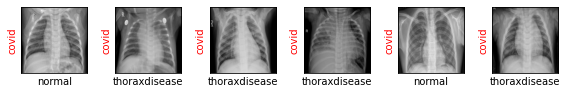

('IM-0315-0001.jpeg', 'person1438_bacteria_3721.jpeg', 'person501_virus_1010.jpeg', 'person382_bacteria_1742.jpeg', 'IM-0015-0001.jpeg', 'person1439_bacteria_3722.jpeg')


In [36]:
show_preds()

In [37]:
# --- EVALUATE ON TEST SET -------------------------------------

def test(dataloader, model, loss_fn):
    image_id, predictions, targets, probabilities= [], [], [], []
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, test_acc = 0, 0
    with torch.no_grad():
        for _, (name, image, labels) in enumerate(dataloader):
            # Compute prediction error
            output = model(image)
            test_loss += loss_fn(output, labels).item()
            # get predictions for train data
            yhat = output.argmax(1)
            # compute test accuracy
            test_acc += (yhat == labels).type(torch.float).sum().item()
            # create list for image file name, predicted labels, actual label and probabilities
            for i in range(len(name)):
                image_id.append(name[i])
                predictions.append(int(yhat[i]))
                targets.append(int(labels[i]))
                probabilities.append(output[i])
    # create dataframe sto store predictions
    pred_df = pd.DataFrame({'image': image_id, 'targets': targets, 'predictions': predictions, 'probabilities': probabilities})
    # get learning rate used in current epoch
    curr_lr = optimizer.param_groups[0]['lr']
    

    test_loss /= num_batches
    test_acc /= size
    
    show_preds()
    print(f"Test Error: \n Accuracy: {(100*test_acc):>0.1f}%, Avg loss: {test_loss:>8f}, LR:{curr_lr} \n")
    return test_acc, test_loss, pred_df

## The Training Loop

Epoch 1
-------------------------------
Train Accuracy: 0.000000 Train loss: 1.769334  [    0/ 4682]
Train Accuracy: 0.821782 Train loss: 0.265666  [  600/ 4682]
Train Accuracy: 0.850746 Train loss: 0.050047  [ 1200/ 4682]
Train Accuracy: 0.868771 Train loss: 0.026742  [ 1800/ 4682]
Train Accuracy: 0.874896 Train loss: 0.042792  [ 2400/ 4682]
Train Accuracy: 0.884232 Train loss: 0.024000  [ 3000/ 4682]
Train Accuracy: 0.888796 Train loss: 0.085036  [ 3600/ 4682]
Train Accuracy: 0.894437 Train loss: 0.028105  [ 4200/ 4682]


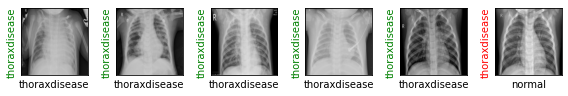

('person1145_virus_1902.jpeg', 'person1414_bacteria_3628.jpeg', 'person114_virus_217.jpeg', 'person373_bacteria_1707.jpeg', 'person1214_bacteria_3166.jpeg', 'IM-0085-0001.jpeg')
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.100063, LR:0.0003 

Epoch 2
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.023827  [    0/ 4682]
Train Accuracy: 0.937294 Train loss: 0.097518  [  600/ 4682]
Train Accuracy: 0.941128 Train loss: 0.005595  [ 1200/ 4682]
Train Accuracy: 0.940753 Train loss: 0.475577  [ 1800/ 4682]
Train Accuracy: 0.941397 Train loss: 0.073079  [ 2400/ 4682]
Train Accuracy: 0.946773 Train loss: 0.004029  [ 3000/ 4682]
Train Accuracy: 0.947310 Train loss: 0.007732  [ 3600/ 4682]
Train Accuracy: 0.947932 Train loss: 0.550063  [ 4200/ 4682]


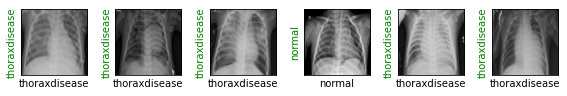

('person845_virus_1489.jpeg', 'person100_bacteria_477.jpeg', 'person258_bacteria_1210.jpeg', 'NORMAL2-IM-0428-0001.jpeg', 'person257_bacteria_1199.jpeg', 'person1059_bacteria_2993.jpeg')
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.117313, LR:0.0003 

Epoch 3
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.030164  [    0/ 4682]
Train Accuracy: 0.962046 Train loss: 0.039786  [  600/ 4682]
Train Accuracy: 0.962687 Train loss: 0.082867  [ 1200/ 4682]
Train Accuracy: 0.955703 Train loss: 0.042935  [ 1800/ 4682]
Train Accuracy: 0.957606 Train loss: 0.551998  [ 2400/ 4682]
Train Accuracy: 0.956088 Train loss: 0.020927  [ 3000/ 4682]
Train Accuracy: 0.956739 Train loss: 0.230494  [ 3600/ 4682]
Train Accuracy: 0.958393 Train loss: 0.035652  [ 4200/ 4682]


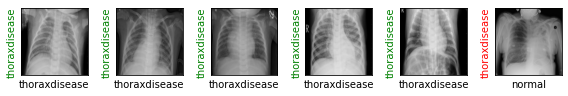

('person317_virus_643.jpeg', 'person2_bacteria_3.jpeg', 'person867_bacteria_2789.jpeg', 'person405_virus_805.jpeg', 'person1401_bacteria_3555.jpeg', '00000462_000.png')
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.103258, LR:0.0003 

Epoch 4
-------------------------------
Train Accuracy: 0.833333 Train loss: 0.158643  [    0/ 4682]
Train Accuracy: 0.950495 Train loss: 0.005424  [  600/ 4682]
Train Accuracy: 0.962687 Train loss: 0.003081  [ 1200/ 4682]
Train Accuracy: 0.962901 Train loss: 0.097085  [ 1800/ 4682]
Train Accuracy: 0.962178 Train loss: 0.111654  [ 2400/ 4682]
Train Accuracy: 0.962741 Train loss: 0.004798  [ 3000/ 4682]
Train Accuracy: 0.962840 Train loss: 0.011054  [ 3600/ 4682]
Train Accuracy: 0.963623 Train loss: 0.034640  [ 4200/ 4682]


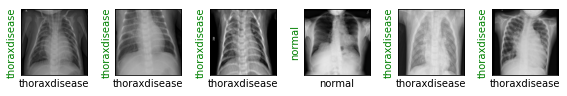

('person764_bacteria_2668.jpeg', 'person598_virus_1151.jpeg', 'person504_bacteria_2133.jpeg', '00000265_004.png', 'person110_virus_208.jpeg', 'person776_virus_1405.jpeg')
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.109289, LR:0.0003 

Epoch 5
-------------------------------
Train Accuracy: 0.666667 Train loss: 0.523794  [    0/ 4682]
Train Accuracy: 0.962046 Train loss: 0.093969  [  600/ 4682]
Train Accuracy: 0.968491 Train loss: 0.113213  [ 1200/ 4682]
Train Accuracy: 0.967885 Train loss: 0.105016  [ 1800/ 4682]
Train Accuracy: 0.971322 Train loss: 0.315296  [ 2400/ 4682]
Train Accuracy: 0.972721 Train loss: 0.033602  [ 3000/ 4682]
Train Accuracy: 0.970882 Train loss: 0.004432  [ 3600/ 4682]
Train Accuracy: 0.969092 Train loss: 0.009833  [ 4200/ 4682]


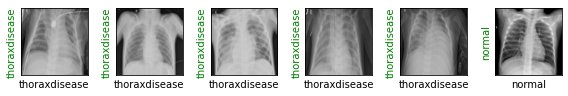

('person393_bacteria_1789.jpeg', 'person21_bacteria_72.jpeg', 'person1372_bacteria_3500.jpeg', 'person742_virus_1365.jpeg', 'person442_virus_901.jpeg', 'IM-0453-0001-0002.jpeg')
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.097756, LR:0.0003 

Epoch 6
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.004682  [    0/ 4682]
Train Accuracy: 0.978548 Train loss: 0.066550  [  600/ 4682]
Train Accuracy: 0.978441 Train loss: 0.048361  [ 1200/ 4682]
Train Accuracy: 0.983942 Train loss: 0.103283  [ 1800/ 4682]
Train Accuracy: 0.980050 Train loss: 0.011654  [ 2400/ 4682]
Train Accuracy: 0.975383 Train loss: 0.044141  [ 3000/ 4682]
Train Accuracy: 0.974764 Train loss: 0.011476  [ 3600/ 4682]
Train Accuracy: 0.976462 Train loss: 0.008826  [ 4200/ 4682]


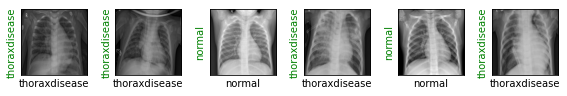

('person1413_bacteria_3620.jpeg', 'person509_bacteria_2145.jpeg', 'IM-0269-0001.jpeg', 'person258_bacteria_1210.jpeg', 'NORMAL2-IM-1256-0001.jpeg', 'person704_virus_1301.jpeg')
Test Error: 
 Accuracy: 95.8%, Avg loss: 0.109665, LR:0.0003 

Epoch 7
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.001623  [    0/ 4682]
Train Accuracy: 0.973597 Train loss: 0.047125  [  600/ 4682]
Train Accuracy: 0.975954 Train loss: 0.099189  [ 1200/ 4682]
Train Accuracy: 0.970100 Train loss: 0.021602  [ 1800/ 4682]
Train Accuracy: 0.966750 Train loss: 0.252447  [ 2400/ 4682]
Train Accuracy: 0.966068 Train loss: 0.008678  [ 3000/ 4682]
Train Accuracy: 0.968941 Train loss: 0.004781  [ 3600/ 4682]
Train Accuracy: 0.970043 Train loss: 0.053172  [ 4200/ 4682]


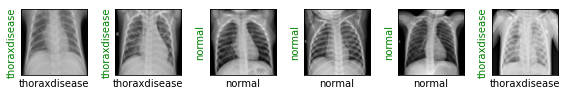

('person934_virus_1595.jpeg', 'person846_virus_1491.jpeg', 'NORMAL2-IM-0414-0001.jpeg', 'NORMAL2-IM-1109-0001.jpeg', 'NORMAL2-IM-0925-0001.jpeg', 'person1333_virus_2301.jpeg')
Test Error: 
 Accuracy: 96.6%, Avg loss: 0.098234, LR:0.0003 

Epoch 8
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.010883  [    0/ 4682]
Train Accuracy: 0.990099 Train loss: 0.196613  [  600/ 4682]
Train Accuracy: 0.983416 Train loss: 0.001935  [ 1200/ 4682]
Train Accuracy: 0.983942 Train loss: 0.004908  [ 1800/ 4682]
Train Accuracy: 0.985453 Train loss: 0.014143  [ 2400/ 4682]
Train Accuracy: 0.986028 Train loss: 0.005255  [ 3000/ 4682]
Train Accuracy: 0.984748 Train loss: 0.013035  [ 3600/ 4682]
Train Accuracy: 0.982644 Train loss: 0.002376  [ 4200/ 4682]


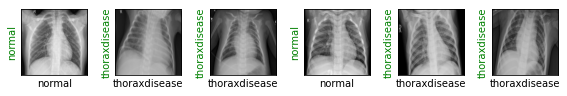

('NORMAL2-IM-1252-0001.jpeg', 'person831_bacteria_2742.jpeg', 'person654_bacteria_2546.jpeg', 'NORMAL2-IM-0569-0001.jpeg', 'person983_virus_1660.jpeg', 'person311_bacteria_1452.jpeg')
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.072983, LR:0.0003 

Performance condition satisfied, saving model..
Epoch 9
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.006458  [    0/ 4682]
Train Accuracy: 0.978548 Train loss: 0.040432  [  600/ 4682]
Train Accuracy: 0.985904 Train loss: 0.000546  [ 1200/ 4682]
Train Accuracy: 0.980066 Train loss: 0.576925  [ 1800/ 4682]
Train Accuracy: 0.978803 Train loss: 0.435314  [ 2400/ 4682]
Train Accuracy: 0.978044 Train loss: 0.004838  [ 3000/ 4682]
Train Accuracy: 0.975874 Train loss: 0.524282  [ 3600/ 4682]
Train Accuracy: 0.976700 Train loss: 0.001462  [ 4200/ 4682]


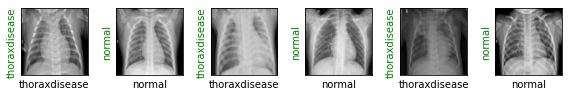

('person543_bacteria_2284.jpeg', 'IM-0517-0001-0001.jpeg', 'person1073_bacteria_3011.jpeg', 'NORMAL2-IM-1252-0001.jpeg', 'person717_bacteria_2618.jpeg', 'NORMAL2-IM-0502-0001.jpeg')
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.105614, LR:0.0003 

Epoch 10
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.003833  [    0/ 4682]
Train Accuracy: 0.981848 Train loss: 0.006875  [  600/ 4682]
Train Accuracy: 0.970149 Train loss: 0.291808  [ 1200/ 4682]
Train Accuracy: 0.973976 Train loss: 0.000589  [ 1800/ 4682]
Train Accuracy: 0.976309 Train loss: 0.000764  [ 2400/ 4682]
Train Accuracy: 0.980040 Train loss: 0.019888  [ 3000/ 4682]
Train Accuracy: 0.982252 Train loss: 0.001610  [ 3600/ 4682]
Train Accuracy: 0.982644 Train loss: 0.151462  [ 4200/ 4682]


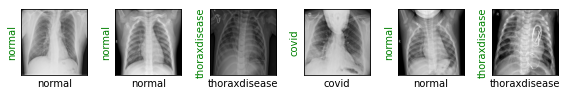

('00000413_000.png', 'IM-0517-0001-0001.jpeg', 'person382_bacteria_1741.jpeg', 'DX.1.2.840.113564.1722810162.20200325171318440480.1203801020003.png', 'IM-0532-0001.jpeg', 'person1180_virus_2015.jpeg')
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.129236, LR:0.0003 

Epoch 11
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.032811  [    0/ 4682]
Train Accuracy: 0.990099 Train loss: 0.000632  [  600/ 4682]
Train Accuracy: 0.989221 Train loss: 0.001651  [ 1200/ 4682]
Train Accuracy: 0.990587 Train loss: 0.060883  [ 1800/ 4682]
Train Accuracy: 0.990025 Train loss: 0.004738  [ 2400/ 4682]
Train Accuracy: 0.990020 Train loss: 0.000110  [ 3000/ 4682]
Train Accuracy: 0.989739 Train loss: 0.001701  [ 3600/ 4682]
Train Accuracy: 0.988588 Train loss: 0.019691  [ 4200/ 4682]


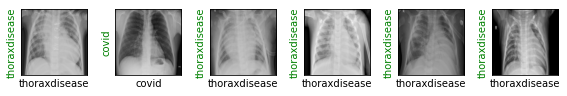

('person487_bacteria_2059.jpeg', 'DX.1.2.840.113564.1722810162.20200405200727037190.1203801020003.png', 'person566_bacteria_2351.jpeg', 'person1320_bacteria_3348.jpeg', 'person442_virus_902.jpeg', 'person158_bacteria_745.jpeg')
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.189679, LR:0.0003 

Epoch 12
-------------------------------
Train Accuracy: 1.000000 Train loss: 0.008725  [    0/ 4682]
Train Accuracy: 0.976898 Train loss: 0.005321  [  600/ 4682]
Train Accuracy: 0.980929 Train loss: 0.000946  [ 1200/ 4682]
Train Accuracy: 0.984496 Train loss: 0.004669  [ 1800/ 4682]
Train Accuracy: 0.983375 Train loss: 0.001779  [ 2400/ 4682]
Train Accuracy: 0.983034 Train loss: 0.007721  [ 3000/ 4682]
Train Accuracy: 0.982529 Train loss: 0.000635  [ 3600/ 4682]
Train Accuracy: 0.983833 Train loss: 0.015281  [ 4200/ 4682]


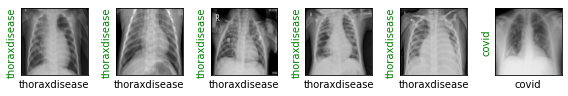

('person500_bacteria_2108.jpeg', 'person739_virus_1361.jpeg', 'person1266_virus_2158.jpeg', 'person1414_bacteria_3628.jpeg', 'person1411_bacteria_3609.jpeg', '5A78BCA9-5B7A-440D-8A4E-AE7710EA6EAD.jpeg')
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.098420, LR:0.0003 

Epoch    12: reducing learning rate of group 0 to 3.0000e-05.
Performance condition satisfied, saving model..
Done! 2 models saved in Capstone Models folder
Loss history saved in Capstone Models folder
Training time: 111.384 minutes


In [38]:
epochs = 12
count = 0
start = time.time()

# lists to store per-epoch loss and accuracy values
history = {} 
history['loss'] = []
history['val_loss'] = []
history['acc'] = []
history['val_acc'] = []

for e in range(epochs):

    print(f"Epoch {e+1}\n-------------------------------")
    
    #train model and get accuracy and loss values
    train_acc, train_loss = train(dl_train, resnet18, loss_fn, optimizer)
    #evaluate model and get accuracy, loss and predictions
    test_acc, test_loss, predictions = test(dl_test, resnet18, loss_fn)
    scheduler.step(test_loss)
    
    # store per-epoch loss and accuracy values
    history['loss'].append(train_loss)
    history['val_loss'].append(test_loss)
    history['acc'].append(train_acc)
    history['val_acc'].append(test_acc)

    if test_acc >= 0.97 :
      count += 1
      print('Performance condition satisfied, saving model..')
      #save model as .pth file
      torch.save(resnet18.state_dict(), os.path.join('/content/drive/MyDrive/Capstone/Models/Resnet18-6/',f'resnet18_epoch{e+1}.pth'))
      #save model predictions as .csv file
      predictions.to_csv(os.path.join('/content/drive/MyDrive/Capstone/Models/Resnet18-6/',f'resnet18_epoch{e+1}.csv'))

print(f'Done! {count} models saved in Capstone Models folder')

#save accuracy and loss history into csv
Resnet18History = pd.DataFrame(history)
Resnet18History.to_csv('/content/drive/MyDrive/Capstone/Models/Resnet18-6/resnethistory.csv', index=False)

print(f'Loss history saved in Capstone Models folder')
end = time.time()
print(f"Training time: {(end-start)/60:.3f} minutes")

## Model Evaluation

Model evaluation will be done on workbook "Model Evalution" 

## Misc

In [138]:
# code to check data in each class
dataset = test_dataset
dataset_size = len(dataset)
classes = dataset.class_names
num_classes = len(dataset.class_names)
img_dict = {}
for i in range(num_classes):
    img_dict[classes[i]] = 0

for i in range(dataset_size):
    name, img, label = dataset[i]
    img_dict[classes[label]] += 1

img_dict

{'covid': 54, 'normal': 211, 'thoraxdisease': 560}